In [1]:
import requests
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
from nltk.stem import WordNetLemmatizer
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
#stop_words = set(stopwords.words('english'))
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# OBJECTIVE

From the previous analysis we found that 

1. The dataset contains features that are not necessary to solve our **multi-classification problem**. 

2. For this **text classification problem**, we are going to build another dataframe that contains ‘Descriptor’ and ‘Compalint Type’



# PIPELINE

1. Text Classifiction problems can be modelled well with Linear SVC, Naive Bayers, Random Forests

2. Modelling the Prediction of Compalint based on Descriptor

In [4]:
df = dd.read_csv("C:\\EZOIC_ASSESSMENT\\Bronx.csv",error_bad_lines=False)
df = df.compute()

In [5]:
def remove_digits(x):
    x = ''.join([i for i in x if not i.isdigit()])
    return x

import string
def remove_punctuation(sentence: str) -> str:
    return sentence.translate(str.maketrans('', '', string.punctuation))

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words('english')

def remove_stop_words(x):
    x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
    return x

def to_lower(x):
    return x.lower()


from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pavani.nrusimhadevar\AppData\Roaming\nltk_dat
[nltk_data]     a...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df["Resolution Description"]= df["Resolution Description"].astype(str)
df["Descriptor"]= df["Descriptor"].astype(str) 

df['Descriptor'] = df['Descriptor'].apply(to_lower)
df["Descriptor"]= df["Descriptor"].astype(str) 
df['Descriptor'] = df['Descriptor'].apply(remove_stop_words)
df['Descriptor'] = df['Descriptor'].apply(remove_digits)
df['Descriptor'] = df['Descriptor'].apply(remove_punctuation)
df['Descriptor']= df['Descriptor'].apply(porter.stem)
df['Resolution Description'] = df['Resolution Description'].apply(to_lower)
df['Resolution Description'] = df['Resolution Description'].apply(remove_stop_words)
df['Resolution Description'] = df['Resolution Description'].apply(remove_digits)
df['Resolution Description'] = df['Resolution Description'].apply(remove_punctuation)
df['Resolution Description']= df['Resolution Description'].apply(porter.stem)

In [7]:
df['Location Type'] = df['Location Type'].astype(str) 
df['Location Type'] = df['Location Type'].apply(to_lower)
df['Location Type'] = df['Location Type'].apply(remove_punctuation)

In [8]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Park Facility Name,Park Borough,Latitude,Longitude,Location,Total_Time,Resolution_Time,Year,Month,DayofWeek
0,27842656,2014-04-14 11:04:00,2015-05-01 14:00:00,DEP,Department of Environmental Protection,Sewer,catch basin sunkendamagedraised sc,nan,10460,880 EAST TREMONT AVENUE,...,Unspecified,BRONX,40.842790,-73.885846,"(40.842789784424255, -73.88584568128475)",382.0,382.0,2014,4,0
1,27842674,2014-04-14 09:32:00,2014-04-15 12:20:00,DEP,Department of Environmental Protection,Water System,hydrant running wc,nan,10467,60 THWAITES PLACE,...,Unspecified,BRONX,40.858885,-73.870400,"(40.85888489249614, -73.87039977678938)",1.0,1.0,2014,4,0
2,27842700,2014-04-14 00:00:00,2014-04-18 00:00:00,DOHMH,Department of Health and Mental Hygiene,Rodent,rat sight,12 family dwelling,10467,3332 HULL AVENUE,...,Unspecified,BRONX,40.877717,-73.873842,"(40.87771733636356, -73.87384175204606)",4.0,4.0,2014,4,0
3,27842709,2014-04-14 00:00:00,2014-04-22 15:40:43,DOHMH,Department of Health and Mental Hygiene,Rodent,rat sight,3 family apt building,10463,3052 KINGSBRIDGE AVENUE,...,Unspecified,BRONX,40.879075,-73.907260,"(40.87907471506111, -73.90725980373738)",8.0,8.0,2014,4,0
4,27842720,2014-04-14 15:51:18,2014-04-14 15:51:18,DOT,Department of Transportation,Street Condition,pothol,nan,10472,NaN,...,Unspecified,BRONX,40.834769,-73.869941,"(40.83476936593012, -73.86994082616778)",0.0,0.0,2014,4,0


In [9]:
df= df[df['Longitude'].notnull()]
df= df[df['Latitude'].notnull()]
df= df[df['Location'].notnull()]
df['Complaint Type'] = df['Complaint Type'].apply(remove_punctuation)
df['Complaint Type'] = df['Complaint Type'].apply(to_lower)
df[['Complaint Type','Descriptor','Resolution Description']].head()

,Complaint Type,Descriptor,Resolution Description
0,sewer,catch basin sunkendamagedraised sc,department environmental protection inspected ...
1,water system,hydrant running wc,department environment protection inspected co...
2,rodent,rat sight,department health mental hygiene review compla...
3,rodent,rat sight,department health mental hygiene review compla...
4,street condition,pothol,department transportation determined complaint...


#### Target Variable Rephrasing

In [10]:
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("heat") ]["Complaint Type"].unique(),'HeatComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("noise") ]["Complaint Type"].unique(), 'NoiseComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("construction|plumbing") ]["Complaint Type"].unique(),'Construction/PlumbingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dof") ]["Complaint Type"].unique(),'DOFComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("parking|blocked driveway|park") ]["Complaint Type"].unique(),'ParkingComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("paint") ]["Complaint Type"].unique(),'Paint/PlasterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("water") ]["Complaint Type"].unique(),'WaterComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("dirt|sanitation condition") ]["Complaint Type"].unique(),'SanitationComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("highway") ]["Complaint Type"].unique(),'HighwayComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['street light condition', 'street condition',
       'street sign  damaged', 'sidewalk condition', 'dead tree',
       'street sign  dangling', 'street sign  missing', 'damaged tree',
       'new tree request', 'illegal tree damage',
       'rootsewersidewalk condition', 'overgrown treebranches',
       'request xmas tree collection', 'deaddying tree',
       'dep sidewalk condition','graffiti','derelict vehicles',
       'for hire vehicle complaint', 'derelict vehicle',
       'for hire vehicle report', 'abandoned vehicle',
       'city vehicle placard complaint'],'StreetComplaints')

df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("sewer|sewage") ]["Complaint Type"].unique(),'SewerComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(df[df['Complaint Type'].str.contains("homeless") ]["Complaint Type"].unique(),'HomelessComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['traffic signal condition', 'traffic'],'TrafficComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['taxi complaint', 'taxi report', 'taxi compliment',
       'green taxi report', 'dispatched taxi complaint'],'TaxiComplaints')
df['Complaint Type'] = df['Complaint Type'].replace(['doorwindow', 'flooringstairs', 'buildinguse', 'outside building',
       'vacant apartment', 'building marshals office',
       'building condition','elevator'],'BuildingComplaints')
pd.set_option('display.max_rows', None)
df['Complaint Type'].value_counts()
df.loc[~df["Complaint Type"].isin(['NoiseComplaints',
'HeatComplaints',                           
'StreetComplaints',                         
'Construction/PlumbingComplaints',                    
'SanitationComplaints',                     
'WaterComplaints',                         
'BuildingComplaints',                       
'Paint/PlasterComplaints',                   
'TaxiComplaints',                           
'HomelessComplaints',
'DOFComplaints',
'HighwayComplaints',
'ParkingComplaints',
'broken muni meter',                        
'rodent',                                   
'consumer complaint',                      
'electric',                                  
'general',                                 
'SewerComplaints',                          
'request large bulky item collection',      
'air quality',                                
'nonconst',                                 
'TrafficComplaints',                         
'vending',                                   
'food establishment',                       
'missed collection all materials' ]), "Complaint Type"] = "Other Complaints"

In [11]:
df['Complaint Type'] = df['Complaint Type'].replace(['vending'],'StreetComplaints')
df['Complaint Type'].value_counts()

NoiseComplaints                        645002
HeatComplaints                         598267
Construction/PlumbingComplaints        310803
StreetComplaints                       310786
Other Complaints                       291572
ParkingComplaints                      266078
Paint/PlasterComplaints                188854
WaterComplaints                        183290
BuildingComplaints                     175017
SanitationComplaints                    82271
electric                                72008
rodent                                  50696
nonconst                                47461
general                                 40782
SewerComplaints                         36511
consumer complaint                      24213
TrafficComplaints                       21655
missed collection all materials         19081
request large bulky item collection     18212
broken muni meter                       12395
HomelessComplaints                       6170
air quality                       

#### Location Type Rephrasing

In [12]:
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("residential") ]["Location Type"].unique(),'RESIDENTIAL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("school") ]["Location Type"].unique(),'SCHOOL')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("apartment") ]["Location Type"].unique(),'APARTMENT')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("comercial|commercial") ]["Location Type"].unique(),'COMMERCIAL')
df['Location Type'] = df['Location Type'].replace(['public gardenpark', 'park', 'parkplayground', 'public parkgarden'],'PARK')
df['Location Type'] = df['Location Type'].replace(df[df['Location Type'].str.contains("restaurant") ]["Location Type"].unique(),'RESTAURANT')


In [13]:
df['Location Type'].value_counts()

RESIDENTIAL                           2047325
nan                                    486178
streetsidewalk                         426525
street                                 164562
sidewalk                               131392
COMMERCIAL                              33866
3 family apt building                   27671
RESTAURANT                              15672
12 family dwelling                      13036
PARK                                    11105
lot                                     11014
APARTMENT                                7920
mixed use                                6321
other explain below                      6196
highway                                  5447
3 family mixed use building              4206
SCHOOL                                   3066
curb                                     2149
streetcurbside                           1964
bus stop shelter                         1936
other                                    1816
vacant lot                        

#### Status

In [14]:
df.loc[((df['Status']!='Closed') & (df['Year'] == 2012) 
       & (df['Resolution Description'].str.contains("investigated|submitted|reviewed|inspected"))) , "Status"] = "Closed"

In [15]:
df.loc[((df['Status']!='Closed' ) 
       & (df['Descriptor'].str.contains("derelict vehicl") ) 
       & (df['Resolution Description'].str.contains("removed"))) , "Status"] = "Closed"

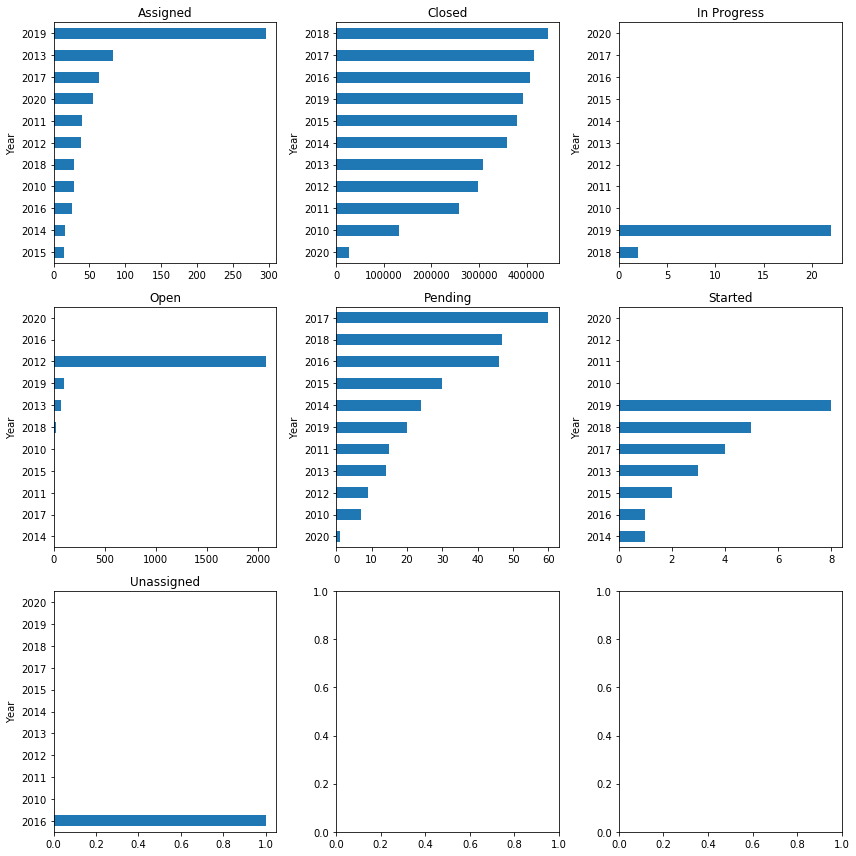

In [16]:
borough_comp = df.groupby(['Year','Status']).size().unstack()

col_number = 3
row_number = 3
fig, axes = plt.subplots(row_number,col_number, figsize=(12,12))

for i, (label,col) in enumerate(borough_comp.iteritems()):
    ax = axes[int(i/col_number), i%col_number]
    col = col.sort_values(ascending=True)[:15]
    col.plot(kind='barh', ax=ax)
    ax.set_title(label)
    
plt.tight_layout()

In [17]:
df = df[df['Location Type']!='nan']
df = df[df['Resolution Description']!='nan']

In [18]:
df.head(2).T

,2,3
Unique Key,27842700,27842709
Created Date,2014-04-14 00:00:00,2014-04-14 00:00:00
Closed Date,2014-04-18 00:00:00,2014-04-22 15:40:43
Agency,DOHMH,DOHMH
Agency Name,Department of Health and Mental Hygiene,Department of Health and Mental Hygiene
Complaint Type,rodent,rodent
Descriptor,rat sight,rat sight
Location Type,12 family dwelling,3 family apt building
Incident Zip,10467,10463
Incident Address,3332 HULL AVENUE,3052 KINGSBRIDGE AVENUE


In [19]:
df1 = df[['Agency','Location Type','Complaint Type','Descriptor','Resolution_Time','Total_Time','Year','Month','DayofWeek','Status','Resolution Description']]

In [20]:
df1.shape

(2913822, 11)

In [21]:
#df_model = df1.head(60000)

In [22]:
df_model = df1

In [23]:
df_model.head()

,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description
2,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...
3,DOHMH,3 family apt building,rodent,rat sight,8.0,8.0,2014,4,0,Closed,department health mental hygiene review compla...
8,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item
9,DSNY,sidewalk,SanitationComplaints,dead anim,0.0,0.0,2014,4,0,Closed,department sanitation investigated complaint f...
10,HPD,RESIDENTIAL,Other Complaints,refriger,8.0,8.0,2014,4,0,Closed,department housing preservation development in...


### Create a new column 'complaint_id' with encoded Complaint Types

In [24]:
df_model['complaint_id'] = df_model['Complaint Type'].factorize()[0]
complaint_id_df = df_model[['Complaint Type', 'complaint_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(complaint_id_df.values)
id_to_category = dict(complaint_id_df[['complaint_id', 'Complaint Type']].values)

# New dataframe
df_model.head()

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description,complaint_id
2,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...,0
3,DOHMH,3 family apt building,rodent,rat sight,8.0,8.0,2014,4,0,Closed,department health mental hygiene review compla...,0
8,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1
9,DSNY,sidewalk,SanitationComplaints,dead anim,0.0,0.0,2014,4,0,Closed,department sanitation investigated complaint f...,2
10,HPD,RESIDENTIAL,Other Complaints,refriger,8.0,8.0,2014,4,0,Closed,department housing preservation development in...,3


### Text Preprocessing

In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

In [26]:
df_model.head()

,Agency,Location Type,Complaint Type,Descriptor,Resolution_Time,Total_Time,Year,Month,DayofWeek,Status,Resolution Description,complaint_id
2,DOHMH,12 family dwelling,rodent,rat sight,4.0,4.0,2014,4,0,Closed,department health mental hygiene review compla...,0
3,DOHMH,3 family apt building,rodent,rat sight,8.0,8.0,2014,4,0,Closed,department health mental hygiene review compla...,0
8,DSNY,street,StreetComplaints,derelict vehicl,0.0,0.0,2014,4,0,Closed,department sanitation removed item,1
9,DSNY,sidewalk,SanitationComplaints,dead anim,0.0,0.0,2014,4,0,Closed,department sanitation investigated complaint f...,2
10,HPD,RESIDENTIAL,Other Complaints,refriger,8.0,8.0,2014,4,0,Closed,department housing preservation development in...,3


**TF/IDF**

1. TERM FREQUENCY (TF)  = Number of times term appears in doc / Total number of words in doc

2. IDF = ln(no of docs / no of docs term appears in)

3. TF-IDF gives **word frequency** scores

4. ngrams(1,2) --> gives UNIGRAMS AND BIGRAMS

5. min_df: **remove the words** from the vocabulary which have occurred in less than ‘min_df’ number of files

As we knew descriptor is one of the important feature

### TFIDF on "Descriptor"

In [27]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df_model['Descriptor']).toarray()

labels = df_model.complaint_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 2913822 complaints is represented by 1111 features (TF-IDF score of unigrams and bigrams)


#### Trying to Find most correlated terms of descriptor for each complaint type

In [28]:
 #Finding the three most correlated terms with each of the complaint categories
N = 3
for Product, complaint_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == complaint_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("\n==> %s:" %(Product))
    print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> BuildingComplaints:
  * Most Correlated Unigrams are: fram, door, floor
  * Most Correlated Bigrams are: window pan, door fram, window fram

==> Construction/PlumbingComplaints:
  * Most Correlated Unigrams are: toilet, waterleak, basinsink
  * Most Correlated Bigrams are: entire build, loud musicparti, water suppli

==> DOFComplaints:
  * Most Correlated Unigrams are: info, statu, payment
  * Most Correlated Bigrams are: refundcredit info, info statu, payment post

==> HeatComplaints:
  * Most Correlated Unigrams are: entire, build, heat
  * Most Correlated Bigrams are: loud talk, loud musicparti, entire build

==> HighwayComplaints:
  * Most Correlated Unigrams are: painted, pothole, highway
  * Most Correlated Bigrams are: graffiti highway, painted linemark, pothole highway

==> HomelessComplaints:
  * Most Correlated Unigrams are: musicparti, loud, nan
  * Most Correlated Bigrams are: loud talk, entire build, loud musicparti

==> NoiseComplaints:
  * Most Correlated Unigrams a

############################################################################################

1. Multinominal Niave Bayes is most suitable for **word counts** where data are typically represented as word vector counts and  ignores non-occurrences of a feature i

2. Naive Bayes is a simplified version of Bayes Theorem, where all features are assumed **conditioned independent** to each other (the classifiers), P(x|y) where x is the feature and y is the classifier

#############################################################################################

1. Linear SVC works well on text classification is a part of SVM best for multi class text classification

2. For larger datasts SVM is not a better option as compared to naive bayes it takes more time 

3. If classes are over lapping( not in the case of our exampels) it doesnt work well

 

In [29]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

MemoryError: Unable to allocate 19.3 GiB for an array with shape (2331046, 1111) and data type float64

In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

#### Model Evaluation

In [ ]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df_model.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Classification report
from sklearn import metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df_model['Complaint Type'].unique()))

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=complaint_id_df['Complaint Type'].values, 
            yticklabels=complaint_id_df['Complaint Type'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - RF\n", size=10);

### Seeing what complaints are classified different

In [ ]:
for predicted in complaint_id_df.complaint_id:
    for actual in complaint_id_df.complaint_id:
        if predicted != actual and conf_mat[actual, predicted] >= 20:
            print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], 
                                                           id_to_category[predicted], 
                                                           conf_mat[actual, predicted]))
            display(df_model.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Complaint Type','Descriptor','Resolution Description']])
            print('')

#### Most correlated terms in each compalint

In [ ]:
model.fit(features, labels)

N = 4
for Product, complaint_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[complaint_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
    print("\n==> '{}':".format(Product))
    print("  * Top unigrams: %s" %(', '.join(unigrams)))
    print("  * Top bigrams: %s" %(', '.join(bigrams)))

### Predictions

In [ ]:
X = df_model['Descriptor']
y = df_model['Complaint Type']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

##### I am predicting my model for new descriptors

In [ ]:
new_descriptor1 = """loud"""
print(model.predict(fitted_vectorizer.transform([new_descriptor1])))

In [ ]:
new_descriptor2 = """rod"""
print(model.predict(fitted_vectorizer.transform([new_descriptor2])))

In [ ]:
new_descriptor3 = """dirty"""
print(model.predict(fitted_vectorizer.transform([new_descriptor3])))

##### TF IDF Vectorization

cv = CountVectorizer(min_df=10)
X_agency = cv.fit_transform(df_model['Agency'])
print(X_agency)

##### Apply TFIDF to "resolution description", 
tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_description = tv.fit_transform(df_model['Resolution Description'])

tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
X_descriptor = tv.fit_transform(df_model['Descriptor'])

lb = LabelBinarizer(sparse_output=True)
X_status = lb.fit_transform(df_model['Status'])

lb = LabelBinarizer(sparse_output=True)
X_comtype = lb.fit_transform(df_model['Complaint Type'])

lb = LabelBinarizer(sparse_output=True)
X_loctype = lb.fit_transform(df_model['Location Type'])

##### Create our final sparse matrix
X_dummies = csr_matrix(pd.get_dummies(df_model[['Total_Time', 'Resolution_Time','Year','Month','DayofWeek']], sparse=True).values)

###### Combine everything together
sparse_merge = hstack((X_dummies, X_description, X_descriptor, X_status, X_loctype)).tocsr()

print("nrows",sparse_merge.shape[0])

In [36]:
import string
import spacy
import pickle

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import train_test_split
from dask_ml.feature_extraction.text import HashingVectorizer
from dask_ml.wrappers import Incremental
from dask_ml.metrics import accuracy_score

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report

In [60]:
df_model.shape

(2913822, 12)

### DASK ML

In [61]:
from dask import dataframe as dd 
sd = dd.from_pandas(df_model, npartitions=3)
print (sd)

Dask DataFrame Structure:
               Agency Location Type Complaint Type Descriptor Resolution_Time Total_Time   Year  Month DayofWeek  Status Resolution Description complaint_id
npartitions=3                                                                                                                                               
0              object        object         object     object         float64    float64  int64  int64     int64  object                 object        int64
37128             ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...          ...
73262             ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...          ...
128433            ...           ...            ...        ...             ...        ...    ...    ...       ...     ...                    ...          ...
Dask Name: from_pandas, 3 tasks


In [62]:
from dask.distributed import Client

client = Client(threads_per_worker=2,n_workers=5, memory_limit='3GB')
client

C:\Anaconda\lib\site-packages\distributed\dashboard\core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:49610 Dashboard: http://127.0.0.1:49613/status,Cluster Workers: 5 Cores: 10 Memory: 15.00 GB


In [63]:
X = sd['Descriptor']
ylabels = sd['Complaint Type']

In [64]:
keys = np.unique(ylabels.compute())
values = class_weight.compute_class_weight('balanced',
                                           keys,
                                           ylabels.compute())
class_weights = dict(zip(keys, values))


In [65]:
class_weights

{'BuildingComplaints': 1.0711572734330888,
 'Construction/PlumbingComplaints': 0.44199607549038167,
 'DOFComplaints': 146.10018050541515,
 'HeatComplaints': 0.20293489361773256,
 'HighwayComplaints': 24.39896503215434,
 'HomelessComplaints': 22.086456248863016,
 'NoiseComplaints': 0.19902405319143704,
 'Other Complaints': 0.466640979025817,
 'Paint/PlasterComplaints': 0.6428735954758702,
 'ParkingComplaints': 0.46665174058599923,
 'SanitationComplaints': 1.4757235234772885,
 'SewerComplaints': 77.03632614213198,
 'StreetComplaints': 0.610796540760268,
 'TaxiComplaints': 78.8884015594542,
 'TrafficComplaints': 31.874310842740876,
 'WaterComplaints': 1.896367654868639,
 'broken muni meter': 9.79501815248084,
 'consumer complaint': 804.0347682119206,
 'electric': 1.6860522441950894,
 'food establishment': 20.66540425531915,
 'general': 2.992291861783408,
 'missed collection all materials': 6.787948674941295,
 'nonconst': 2.5580845325635786,
 'rodent': 2.4951036807168254}

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [67]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

In [68]:
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

#### Hashing Vecorization (Just like TF-IDF Vectorization in Pandas)

1. text vectorizer implementation uses the hashing trick to find the **token string name to feature integer index mapping**

2. **Less Memory** scaled for Large Data Sets

3. parallel pipeline as there is no state computed during fit.


In [69]:
from dask_ml.feature_extraction.text import HashingVectorizer
hw_vector = HashingVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1, 2), n_features=2**20)

In [82]:
hw_vector

HashingVectorizer(alternate_sign=True, analyzer='word', binary=False,
                  decode_error='strict', dtype=<class 'numpy.float64'>,
                  encoding='utf-8', input='content', lowercase=True,
                  n_features=1048576, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, stop_words=None, strip_accents=None,
                  token_pattern='(?u)\\b\\w\\w+\\b',
                  tokenizer=<function spacy_tokenizer at 0x0000019CF9CE6828>)

In [70]:
%time
Feature_pipeline = Pipeline([('vectorizer', hw_vector)])
Pipeline_Model = Feature_pipeline.fit(X_train.values)

Wall time: 0 ns


In [71]:
Text_preprocess_pipe = pickle.dumps(Pipeline_Model)
Pipeline_Model = pickle.loads(Text_preprocess_pipe)

In [72]:
%time
X_transformed = Pipeline_Model.transform(X_train)

Wall time: 0 ns


In [73]:
%%time
import joblib
estimator = SGDClassifier(random_state=10, max_iter=200, loss='modified_huber',class_weight = class_weights, n_jobs=-1)
classifier = Incremental(estimator)
Model = classifier.fit(X_transformed,y_train,classes=list(class_weights.keys()))

Wall time: 25 s


In [74]:
predictions = Model.predict(Pipeline_Model.transform(X_test))
predictions

dask.array<_predict, shape=(nan,), dtype=int32, chunksize=(nan,), chunktype=numpy.ndarray>

In [76]:
ML_Model = pickle.dumps(Model)

In [77]:
%time
Model = pickle.loads(ML_Model)
# X = Model.predict_proba(X_transformed).compute()

Wall time: 0 ns


In [78]:
%time
x_test_transformed = Pipeline_Model.transform(X_test)
y_pred = Model.predict(x_test_transformed).compute()

Wall time: 0 ns


In [79]:
%time
print(classification_report(y_train,Model.predict(Pipeline_Model.transform(X_train)).compute()))

Wall time: 0 ns
                                 precision    recall  f1-score   support

             BuildingComplaints       0.75      1.00      0.85     79328
Construction/PlumbingComplaints       0.99      0.75      0.86    192176
                  DOFComplaints       1.00      1.00      1.00       582
                 HeatComplaints       1.00      1.00      1.00    418783
              HighwayComplaints       0.89      0.84      0.86      3427
             HomelessComplaints       0.67      1.00      0.80      3863
                NoiseComplaints       1.00      1.00      1.00    426672
               Other Complaints       0.91      0.97      0.94    181644
        Paint/PlasterComplaints       1.00      0.99      0.99    132160
              ParkingComplaints       1.00      0.98      0.99    182252
           SanitationComplaints       0.99      1.00      1.00     57485
                SewerComplaints       1.00      1.00      1.00      1112
               StreetComplaints   

In [80]:
%time
print(classification_report(y_test, y_pred))

Wall time: 0 ns
                                 precision    recall  f1-score   support

             BuildingComplaints       0.75      1.00      0.86     34016
Construction/PlumbingComplaints       0.99      0.75      0.86     82508
                  DOFComplaints       1.00      1.00      1.00       249
                 HeatComplaints       1.00      1.00      1.00    179484
              HighwayComplaints       0.90      0.84      0.87      1549
             HomelessComplaints       0.67      1.00      0.80      1634
                NoiseComplaints       1.00      1.00      1.00    183351
               Other Complaints       0.91      0.97      0.94     78533
        Paint/PlasterComplaints       1.00      0.99      0.99     56694
              ParkingComplaints       1.00      0.98      0.99     77919
           SanitationComplaints       0.99      1.00      1.00     24786
                SewerComplaints       1.00      1.00      1.00       464
               StreetComplaints   

In [81]:
client.close()